### **Model Training Process**

**Objective**: The goal of this process is to train a machine learning model that can accurately predict the target variable. During this phase, we will select the appropriate model, tune hyperparameters, and evaluate performance using cross-validation and relevant metrics. Additionally, we will handle data splitting into training and testing sets, implement regularization if necessary, and track performance to ensure the model generalizes well to unseen data


##### **First Step:** Import libraries and load data


In [1]:
# Importing libraries
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


# Load the processed data
df = pd.read_csv("../data/processed/MLA_100k_cleaned.csv")

---


##### **Second Step:** Choosing variables and separating sets


In [2]:
X = df[[
    'base_price',
    'non_mercado_pago_payment_methods',
    'seller_id',
    'variations',
    'price',
    'attributes',
    'pictures',
    'initial_quantity',
    'sold_quantity',
    'available_quantity',
    'seller_address_longitude',
    'seller_address_id',
    'seller_address_latitude',
    'pixels',
    'max_pixels',
    'lifetime publication',
    'last_update'
]]

y = df['condition'].apply(lambda x: 1 if x == 'new' else 0)  # 1 = new, 0 = used

In [3]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

---


##### **Third Step:** List of models and training


In [4]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'XGBBoost': XGBClassifier(eval_metric='logloss')
}

In [5]:
# Train and evaluate models
results_df = pd.DataFrame()


for name, model in models.items():
    print(f'Training the {name} model')
    model.fit(X_train, y_train)


    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]


    # Performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)


    # Extract metrics from the classification report for classes 0 and 1
    precision_0 = report['0']['precision']
    recall_0 = report['0']['recall']
    f1_0 = report['0']['f1-score']
    precision_1 = report['1']['precision']
    recall_1 = report['1']['recall']
    f1_1 = report['1']['f1-score']


    # Create a temporary DataFrame with the current results
    temp_df = pd.DataFrame({
        'Model': [name],
        'Accuracy': [accuracy],
        'AUC-ROC': [auc_roc],
        'Precision_0': [precision_0],
        'Recall_0': [recall_0],
        'F1_0': [f1_0],
        'Precision_1': [precision_1],
        'Recall_1': [recall_1],
        'F1_1': [f1_1]
    })

    # Filter the temporary DataFrame to remove empty or all NA entries
    temp_df = temp_df.dropna(how='all', axis=1)

    # Contatenate the temporary DataFrame with the main DataFrame
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

Training the Random Forest model
Training the Gradient Boosting model
Training the K-Nearest Neighbors model
Training the Logistic Regression model
Training the XGBBoost model


---


##### **Fourth step:** Metrics review and choice of best model


_Let's make bar charts to see the metrics that we obtained_


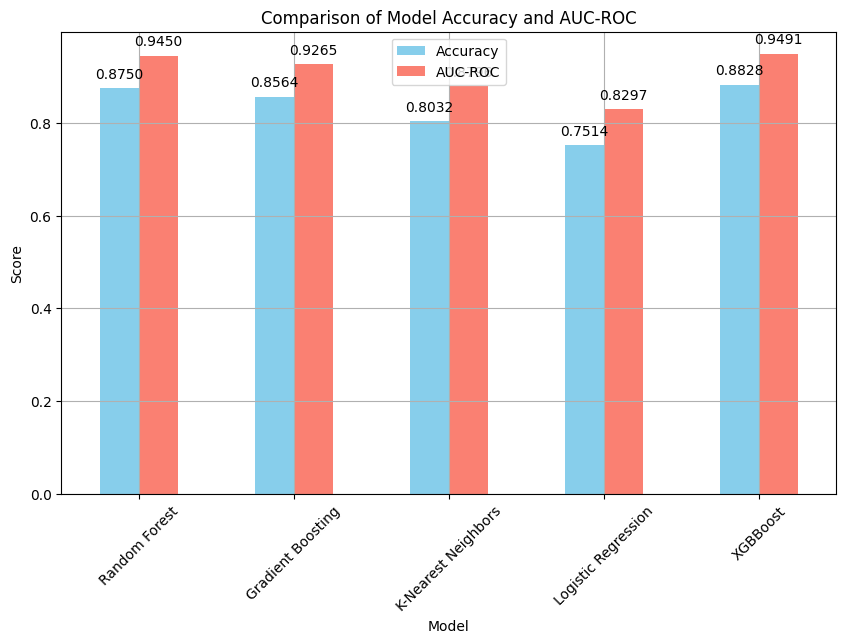

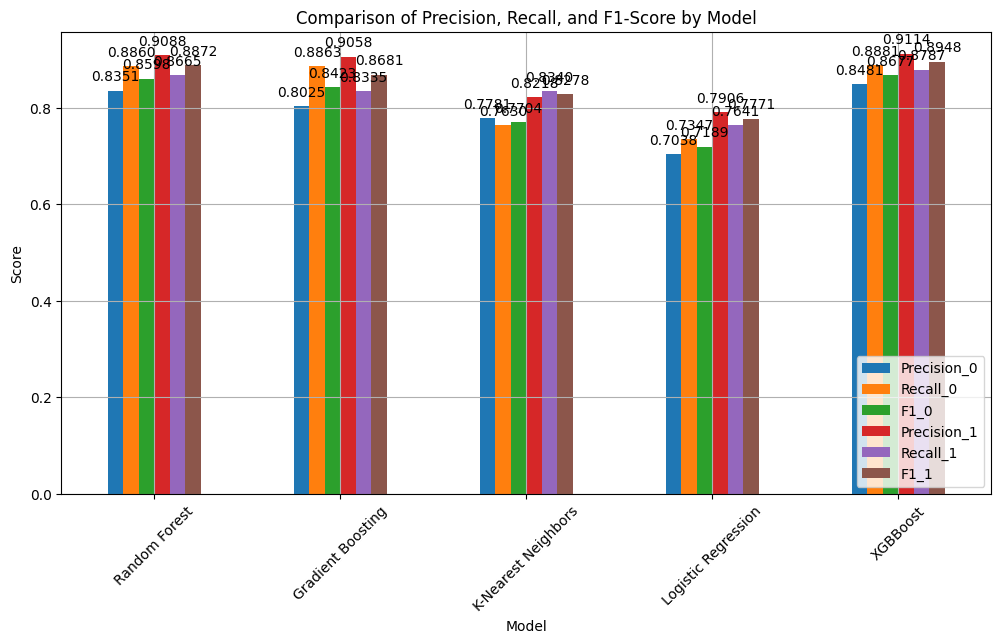

In [6]:
# Ensure that the index is unique for the models
results_df = results_df.reset_index(drop=True).drop_duplicates(
    subset='Model').set_index('Model')


# 1. Bar chart for Accuracy and AUC-ROC
fig, ax = plt.subplots(figsize=(10, 6))
bar_plot = results_df[['Accuracy', 'AUC-ROC']].plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])

# Title and labels
plt.title('Comparison of Model Accuracy and AUC-ROC')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True)

# Add text labels on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.4f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 10),
                      textcoords='offset points')

plt.show()

# 2. Multiple bar chart for Precision, Recall, and F1-Score
metrics = ['Precision_0', 'Recall_0', 'F1_0',
           'Precision_1', 'Recall_1', 'F1_1']

fig, ax = plt.subplots(figsize=(12, 6))
bar_plot = results_df[metrics].plot(kind='bar', ax=ax)

# Title and labels
plt.title('Comparison of Precision, Recall, and F1-Score by Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower left')
plt.grid(True)

# Add text labels on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.4f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 10),
                      textcoords='offset points')

plt.show()

#### **Fifth Step**: Export the best model as pkl


In [7]:
# Create the XGBoost model again
xgboost_model = XGBClassifier(eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

# Save the model to disk
path = '../artifacts/models/model.pkl'
with open(path, 'wb') as f:
    pickle.dump(xgboost_model, f)

print(f"Succesfully saved XGBoost model to {path}")

Succesfully saved XGBoost model to ../artifacts/models/model.pkl


---


#### **Conclusions**

##### **First Graph: Comparison of Accuracy and AUC-ROC**
- **XGBoost**:
  - Highest **accuracy (0.8828)** and **AUC-ROC (0.9491)**, indicating the best overall performance. It excels in both correctly classifying the instances and discriminating between the two classes (new vs used).

- **Random Forest**:
  - **Accuracy of 0.8750** and **AUC-ROC of 0.9450**, slightly behind XGBoost, but still performing very well in both metrics.

- **Gradient Boosting**:
  - **Accuracy of 0.8564** and **AUC-ROC of 0.9265**, showing strong results, though trailing behind XGBoost and Random Forest.

- **Logistic Regression**:
  - **Accuracy of 0.7514** and **AUC-ROC of 0.8297**, which is a noticeable drop in performance compared to the top models, indicating weaker overall capability to both classify correctly and distinguish between classes.

- **K-Nearest Neighbors**:
  - **Accuracy of 0.7514** and **AUC-ROC of 0.8032**, which places it as the weakest model overall in terms of both classification accuracy and class discrimination.

##### **Second Graph: Comparison of Precision, Recall, and F1-Score**
- **XGBoost**:
  - Strong balance across all metrics, with an **F1-Score for the positive class (F1_1 = 0.8848)**, the highest among the models, making it the best choice for predicting new items with precision and recall balanced.

- **Random Forest**:
  - Very competitive with **F1_1 of 0.86872**, showing strong precision and recall for both classes, though slightly behind XGBoost.

- **Gradient Boosting**:
  - **F1_1 of 0.8681**, similar to Random Forest, but marginally lower. It maintains a good balance in both precision and recall, particularly for new items.

- **Logistic Regression**:
  - **F1_1 of 0.74789**, indicating that this model struggles more than the top three models when predicting the positive class (new items). It is less effective at correctly identifying new items compared to the leading models.

- **K-Nearest Neighbors**:
  - **F1_1 of 0.8204**, showing it performs better than Logistic Regression but still weaker than the top three models in terms of positive class prediction.

#### **Final Decision**
- **XGBoost** remains the best model with the highest scores across all key metrics: **accuracy, AUC-ROC, precision, recall, and F1-Score**, making it the most reliable for this classification task.
- **Random Forest** and **Gradient Boosting** are also strong contenders, with similar performances, though slightly weaker than XGBoost.
- **Logistic Regression** and **K-Nearest Neighbors** lag behind in both accuracy and class discrimination, making them less suitable for this problem.


---
